# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

In [2]:
print(hosts)

['1309' '3021' '3370' '3982' '4038' '4258' '4536' '4639' '5584']


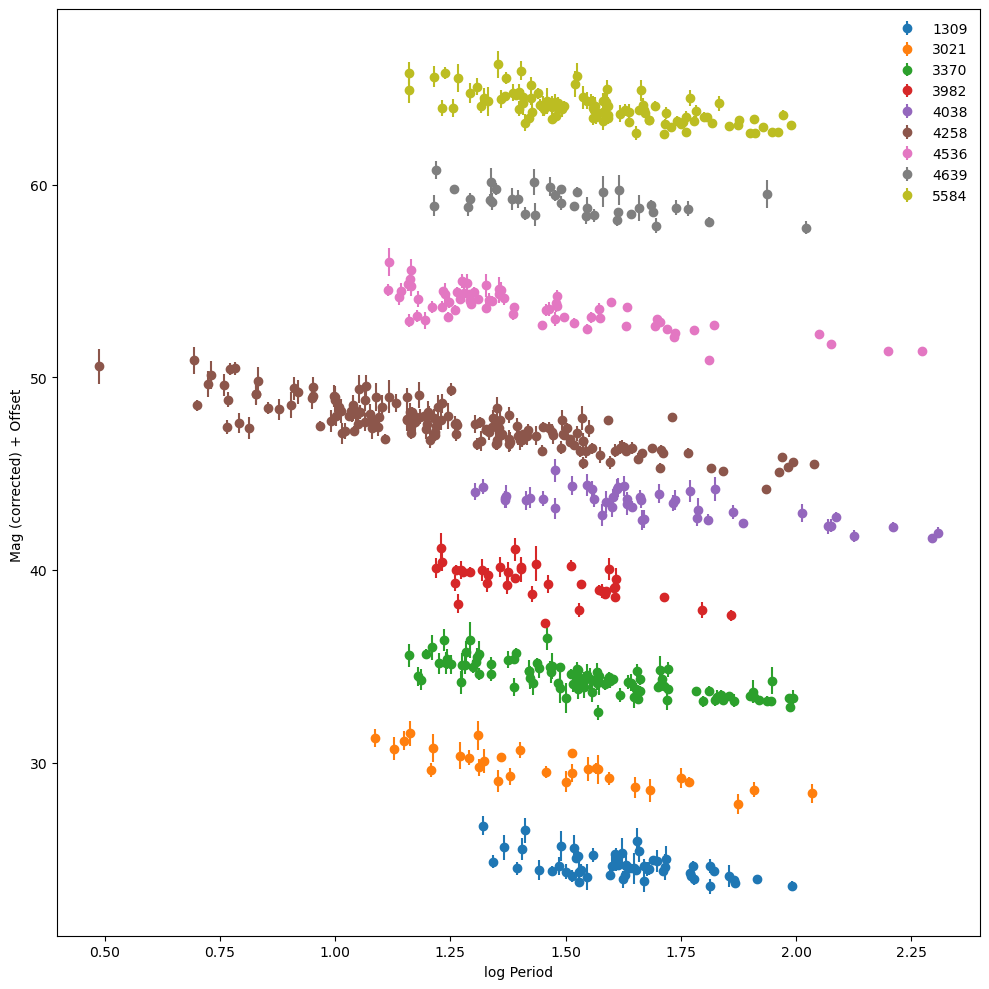

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


## Here I go
With a model defined as:

#### $$ m_{W,mod,i,j} = (\mu_{0,i} − \mu_{0,4258}) + zp_{W,4258} + b_W \cdot log(P_{i,j}) $$

we can write what I'll call the "unscaled" chi square, $\chi^2_u$ as:

#### $$ \chi^2_u = \sum_{i}\sum_{j} \frac{(m_{W,mod,i,j} - m_{W,obs,i,j})^2}{\sigma_M^2 + \sigma_{int}^2} $$

where $m_{W,obs,i,j}$ is the observed magnitude, and $\sigma_{M}$ is the error in that observation.  So, the negative log likelihood is:

#### $$ L_{log} = const. - \frac{\chi^2_u}{2} $$

and the likelihood is 

#### $$ L = C \cdot e^{L_{log}} $$

where C is some value whose logarithm gives the constant mentioned in the log likelihood.  I don't feel further detail is necessary as this is ignored by the code.

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

## Let's do it

As the distance modulus $\mu_0$ is relatec to distance $d$ as

#### $$ \mu_0 = 5\log(\frac{d}{10\textrm{pc}}), $$

we can write 

#### $$ \mu_{0,i} - \mu_{0,4258} = 5\log(\frac{d_i}{d_{4258}}), $$

and since at small distances $d\sim\ z$, we can get an estimate of 

#### $$ \mu_{0,i} - \mu_{0,4258} = 5\log(\frac{z_i}{z_{4258}}). $$

Since each unit change in $\mu_0$ is a change by one dex, and this is likely a pretty good estimate, I can then construct a normal prior with a standard deviation of 1 centered at this guess.  It's worth noting that the actual value that I'm fitting is $(\mu_{0,i} − \mu_{0,4258}) + zp_{W,4258}$, so I need to offset all of these guesses with an initial guess for $zp_{W,4258}$, which I'll obtain with some other fit.  Since I'm taking an approximate fit anyway, I might as well use the slope of that fit as my initial guess for $b_W$.  The slope here needs to be negative, and since this is not as well motivated, I'll take as my prior a normal distribution centered at this guess, with the positive 3 sigma level at zero so that positive values are well into the tail of the distribution.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

$\theta$ = [$\mu_{0,i} - \mu_{0,4258}$: 1309, 3021, 3370, 3982, 4038, 4258, 4536, 4639, 5584, $b_W$]

In [4]:
import scipy.stats as st
import scipy.optimize as so
import emcee
import corner
import astropy.table as at
from astropy.io import ascii
from matplotlib.ticker import AutoMinorLocator


def plotutils(ax): # Standard plotting utility
   ax.xaxis.set_minor_locator(AutoMinorLocator())
   ax.yaxis.set_minor_locator(AutoMinorLocator())
   ax.tick_params(which='both', direction='in', right=True, top=True)


def model(intercept, slope, zp, logP):
    mod = intercept + zp + (slope * logP)
    return np.nan_to_num(mod)


def log_likelihood(theta, zpg, sig_int, ceph):
    hosts = ceph.list_hosts()
    x2 = 0.
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        mod = model(theta[i], theta[-1], zpg, ceph.logP)
        x2 += np.sum(((ceph.mobs - mod) ** 2.) / (((ceph.sigma) ** 2.) + ((sig_int) ** 2.)))
    return -x2/2.


def log_prior(theta, bWg, ceph):
    hosts = ceph.list_hosts()
    logP = 0
    for i, ID in enumerate(hosts):
        cent = 5. * np.log10(ceph.redshifts[ID] / ceph.redshifts['4258'])
        if theta[i] < cent - 3. or theta[i] > cent + 3.:
            return -np.inf
        logP += np.log(st.norm.pdf(theta[i], loc=cent, scale=1))
    if theta[-1] < 2. * bWg or theta[-1] > 0:
        return -np.inf
    logP += np.log(st.norm.pdf(theta[-1], loc=bWg, scale=(-bWg/3.)))
    return logP


def log_posterior(theta, zpg=None, bWg=None, sig_int=None, ceph=None):
    lgli = log_likelihood(theta, zpg, sig_int, ceph)
    lgpr = log_prior(theta, bWg, ceph)
    return lgli + lgpr
    

def run_emcee(ceph, zpg, bWg, sig_int, ndim, nwalkers, nsteps):
    hosts = ceph.list_hosts()
    kwargs = {'zpg':zpg, 'bWg':bWg, 'sig_int':sig_int, 'ceph':ceph}
    nburn = nsteps // 10 
    
    np.random.seed(10)
    starting_guesses = np.zeros((nwalkers, ndim))
    for i, ID in enumerate(hosts): # mu_0,i
        cent = 5. * np.log10(ceph.redshifts[ID] / ceph.redshifts['4258'])
        starting_guesses[:, i] = np.random.normal(cent, 1, (nwalkers))
    starting_guesses[:, -1] = np.random.normal(bWg, (-bWg/3.), (nwalkers))
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, kwargs=kwargs)
    state = sampler.run_mcmc(starting_guesses, nburn) # burning in
    sampler.reset()
    
    sampler.run_mcmc(state, nsteps, progress=True);
    return sampler


def make_corner(samples, labels):
    fig = corner.corner(samples, plot_contours=True, show_titles=True, smooth=2, labels=labels)
    return


def visualize_chain(samples, labels):
    # we can visualize the chains
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
    for i in range(samples.shape[1]):
        j, k = np.unravel_index(i, (4,3))
        ax = axs[j][k]
        ax.plot(samples[::10,i], linestyle='-', color='grey', marker='.', alpha=0.1)
        med = np.median(samples[:,i])
        std = np.std(samples[:,i])
        ax.set_ylim(med-3*std, med+3*std) 
        ax.set_ylabel(labels[i])
    return


def duplicate(ceph, mcrc, zp_true):
    hosts = ceph.list_hosts()
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10), dpi=200)
    for i, ID in enumerate(hosts):
        j, k = np.unravel_index(i, (3,3))
        ax = axs[j][k]
        plotutils(ax)
        
        ceph.select(ID)
        mobs = ceph.mobs
        logP = ceph.logP
        sigma_obs = ceph.sigma
        ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', markeredgecolor='k', color='r')
        
        # Median best fit line
        logPmin, logPmax = np.amin(logP), np.amax(logP)
        logPs = np.linspace(logPmin, logPmax + 0.1, 1000)
        mobss = logPs * mcrc[0, -1] + mcrc[0, i] + zp_true
        ax.plot(logPs, mobss, ls='-', color='k')
        
        # 86th percentile best fit lines
        mobss = logPs * mcrc[1, -1] + mcrc[1, i] + zp_true
        ax.plot(logPs, mobss, ls='--', color='k')
        
        mobss = logPs * mcrc[2, -1] + mcrc[2, i] + zp_true
        ax.plot(logPs, mobss, ls='--', color='k')
        
        ax.set_title('n' + ID + ', # = ' + str(len(ceph.mobs)))
        ax.set_xlabel('log Period (days)')
        ax.set_ylabel('Mag (corrected)')
        ax.invert_yaxis()
        plt.subplots_adjust(hspace=0.3)
    return

Text(0, 0.5, 'Mag (corrected)')

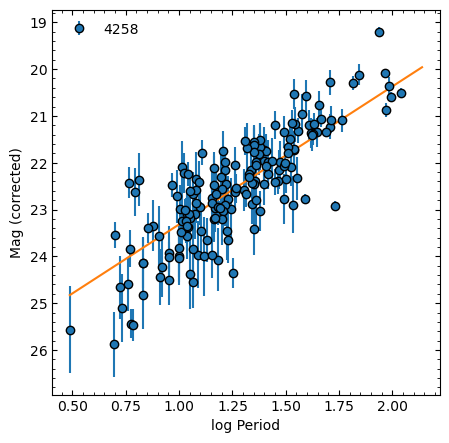

In [5]:
sig_int = 0.08 # Intrinsic sigma measurement from http://dx.doi.org/10.3847/0004-637X/826/1/56

# Get a reasonable guess of zp_W,4258 and b_W
ceph.select('4258')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plotutils(ax)

ceph.select('4258')
mobs = ceph.mobs
logP = ceph.logP
sigma_obs = ceph.sigma
ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', markeredgecolor='k', label='4258')

bWg, zpg = np.polyfit(logP, mobs, 1, w=(sigma_obs ** -1.))
logPmin, logPmax = np.amin(logP), np.amax(logP)
logPs = np.linspace(logPmin, logPmax + 0.1, 1000)
mobss = logPs * bWg + zpg
ax.plot(logPs, mobss, ls='-')
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.invert_yaxis()
ax.set_ylabel('Mag (corrected)')

In [ ]:
ndim = 10
nwalkers = 20
nsteps = 10000
prms = []
for host in hosts:
    prms.append(r'$\mu_{0,' + host + '}$')
prms.append(r'$b_W$')
samp1 = run_emcee(ceph, zpg, bWg, sig_int, ndim, nwalkers, nsteps)
samp1s = samp1.get_chain(flat=True)

In [ ]:
visualize_chain(samp1s, prms)

In [ ]:
make_corner(samp1s, prms)

In [ ]:
mcmc_res = np.percentile(samp1s, [50, 16, 84], axis=0)
corr = mcmc_res[0, 5]
mcmc_res_corr = mcmc_res
for i in range(len(mcmc_res)):
    mcmc_res_corr[i,:-1] = mcmc_res_corr[i,:-1] - mcmc_res[i, 5]
zp_true = zpg + corr

In [ ]:
duplicate(ceph, mcmc_res_corr, zp_true)
print('Note: I display dashed lines as the 16/84th percentile of my fit to show the spread.')

In [ ]:
intercepts = at.Table()
intercepts['ID'] = hosts
intercepts['Riess'] = [3.276, 3.138, 2.835, 2.475, 2.396, 0, 1.567, 2.383, 2.461]
intercepts['emcee'] = mcmc_res_corr[0,:-1]
intercepts['difference'] = intercepts['Riess'] - intercepts['emcee']

print(intercepts)

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and then re-express equation 4 using a substitution of equation 3.

## Write that expression down.

## Woo.

#### $$ \log\ H_0 = \frac{m^{0}_{v,4258} - \mu_{0,4258} + 5a_{\nu} + 25}{5}  = \frac{(m^{0}_{v,i} + 5a_{\nu}) - (\mu_{0,i} - \mu_{0,4258}) - \mu_{0,4258}}{5} + 5 $$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [ ]:
newData = intercepts
newData['emcee sigma'] = np.std(samp1s, axis=0)[:-1]
newData['m-a'] = [16.768, 16.699, 16.545, 15.953, 15.901, 0, 15.147, 16.040, 16.274]
#newData['difsig'] = newData['difference'] / newData['emcee sigma']
newData = newData[newData['emcee'] != 0]
mu0humph = 5*np.log10(7.6E5)

# Run a weighted average to get H0
logH0 = ((newData['m-a'] - newData['emcee'] - mu0humph) / 5) + 5
logH0 = np.sum(logH0 / (newData['emcee sigma'] / 5)) / np.sum(5 / newData['emcee sigma'])
logsig = 1 / np.sum(5 / newData['emcee sigma'])
H0 = 10 ** logH0
sig = 10 ** logsig
print('Hubble constant: ' + str(H0) + ' +/- ' + str(sig) + ' km / s Mpc')